In [1]:
import numpy # linear algebra
import csv # data processing, CSV file I/O
import pandas # data processing, CSV file I/O
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier # sklearn Decision Tree
import operator
from math import log
from collections import Counter

In [2]:
import pandas as pd
import numpy as np

In [3]:
df=pd.read_csv('Thyroid_Diff.csv')

In [4]:
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [5]:
df.shape

(383, 17)

In [6]:
df.dtypes

Age                      int64
Gender                  object
Smoking                 object
Hx Smoking              object
Hx Radiothreapy         object
Thyroid Function        object
Physical Examination    object
Adenopathy              object
Pathology               object
Focality                object
Risk                    object
T                       object
N                       object
M                       object
Stage                   object
Response                object
Recurred                object
dtype: object

In [7]:
# Find number of unique values in object columns
unique_counts = df.select_dtypes(include=['object']).nunique()

# Display unique counts
print(unique_counts)


Gender                  2
Smoking                 2
Hx Smoking              2
Hx Radiothreapy         2
Thyroid Function        5
Physical Examination    5
Adenopathy              6
Pathology               4
Focality                2
Risk                    3
T                       7
N                       3
M                       2
Stage                   5
Response                4
Recurred                2
dtype: int64


In [8]:
df_en=df

In [9]:
def label_encode_column(column):
    unique_values = np.unique(column)
    encoding_map = {value: index for index, value in enumerate(unique_values)}
    return column.map(encoding_map)

# Apply label encoding to all object columns
object_columns = df.select_dtypes(include=['object']).columns
for col in object_columns:
    df_en[col] = label_encode_column(df[col])

# Display the encoded DataFrame
df_en.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,0,0,0,0,2,3,3,2,1,2,0,0,0,0,2,0
1,34,0,0,1,0,2,1,3,2,1,2,0,0,0,0,1,0
2,30,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
3,62,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
4,62,0,0,0,0,2,1,3,2,0,2,0,0,0,0,1,0


In [10]:
df_en['Recurred'].value_counts()

Recurred
0    275
1    108
Name: count, dtype: int64

In [11]:
import numpy as np

class TreeNode():
    def __init__(self, data, feature_idx, feature_val, prediction_probs, information_gain) -> None:
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.prediction_probs = prediction_probs
        self.information_gain = information_gain
        self.feature_importance = self.data.shape[0] * self.information_gain
        self.left = None
        self.right = None

    def node_def(self) -> str:

        if (self.left or self.right):
            return f"NODE | Information Gain = {self.information_gain} | Split IF X[{self.feature_idx}] < {self.feature_val} THEN left O/W right"
        else:
            unique_values, value_counts = np.unique(self.data[:,-1], return_counts=True)
            output = ", ".join([f"{value}->{count}" for value, count in zip(unique_values, value_counts)])            
            return f"LEAF | Label Counts = {output} | Pred Probs = {self.prediction_probs}"

In [12]:
import numpy as np
from collections import Counter

class DecisionTree():
    """
    Decision Tree Classifier
    Training: Use "train" function with train set features and labels
    Predicting: Use "predict" function with test set features
    """

    def __init__(self, max_depth=4, min_samples_leaf=1, 
                 min_information_gain=0.0, numb_of_features_splitting=None,
                 amount_of_say=None) -> None:
        """
        Setting the class with hyperparameters
        max_depth: (int) -> max depth of the tree
        min_samples_leaf: (int) -> min # of samples required to be in a leaf to make the splitting possible
        min_information_gain: (float) -> min information gain required to make the splitting possible
        num_of_features_splitting: (str) ->  when splitting if sqrt then sqrt(# of features) features considered, 
                                                            if log then log(# of features) features considered
                                                            else all features are considered
        amount_of_say: (float) -> used for Adaboost algorithm                                                    
        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.numb_of_features_splitting = numb_of_features_splitting
        self.amount_of_say = amount_of_say

    def _entropy(self, class_probabilities: list) -> float:
        return sum([-p * np.log2(p) for p in class_probabilities if p>0])
    
    def _class_probabilities(self, labels: list) -> list:
        total_count = len(labels)
        return [label_count / total_count for label_count in Counter(labels).values()]

    def _data_entropy(self, labels: list) -> float:
        return self._entropy(self._class_probabilities(labels))
    
    def _partition_entropy(self, subsets: list) -> float:
        """subsets = list of label lists (EX: [[1,0,0], [1,1,1])"""
        total_count = sum([len(subset) for subset in subsets])
        return sum([self._data_entropy(subset) * (len(subset) / total_count) for subset in subsets])
    
    def _split(self, data: np.array, feature_idx: int, feature_val: float) -> tuple:
        
        mask_below_threshold = data[:, feature_idx] < feature_val
        group1 = data[mask_below_threshold]
        group2 = data[~mask_below_threshold]

        return group1, group2
    
    def _select_features_to_use(self, data: np.array) -> list:
        """
        Randomly selects the features to use while splitting w.r.t. hyperparameter numb_of_features_splitting
        """
        feature_idx = list(range(data.shape[1]-1))

        if self.numb_of_features_splitting == "sqrt":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.sqrt(len(feature_idx))))
        elif self.numb_of_features_splitting == "log":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.log2(len(feature_idx))))
        else:
            feature_idx_to_use = feature_idx

        return feature_idx_to_use
        
    def _find_best_split(self, data: np.array) -> tuple:
        """
        Finds the best split (with the lowest entropy) given data
        Returns 2 splitted groups and split information
        """
        min_part_entropy = 1e9
        feature_idx_to_use =  self._select_features_to_use(data)

        for idx in feature_idx_to_use:
            feature_vals = np.percentile(data[:, idx], q=np.arange(25, 100, 25))
            for feature_val in feature_vals:
                g1, g2, = self._split(data, idx, feature_val)
                part_entropy = self._partition_entropy([g1[:, -1], g2[:, -1]])
                if part_entropy < min_part_entropy:
                    min_part_entropy = part_entropy
                    min_entropy_feature_idx = idx
                    min_entropy_feature_val = feature_val
                    g1_min, g2_min = g1, g2

        return g1_min, g2_min, min_entropy_feature_idx, min_entropy_feature_val, min_part_entropy

    def _find_label_probs(self, data: np.array) -> np.array:

        labels_as_integers = data[:,-1].astype(int)
        # Calculate the total number of labels
        total_labels = len(labels_as_integers)
        # Calculate the ratios (probabilities) for each label
        label_probabilities = np.zeros(len(self.labels_in_train), dtype=float)

        # Populate the label_probabilities array based on the specific labels
        for i, label in enumerate(self.labels_in_train):
            label_index = np.where(labels_as_integers == i)[0]
            if len(label_index) > 0:
                label_probabilities[i] = len(label_index) / total_labels

        return label_probabilities

    def _create_tree(self, data: np.array, current_depth: int) -> TreeNode:
        """
        Recursive, depth first tree creation algorithm
        """

        # Check if the max depth has been reached (stopping criteria)
        if current_depth > self.max_depth:
            return None
        
        # Find best split
        split_1_data, split_2_data, split_feature_idx, split_feature_val, split_entropy = self._find_best_split(data)
        
        # Find label probs for the node
        label_probabilities = self._find_label_probs(data)

        # Calculate information gain
        node_entropy = self._entropy(label_probabilities)
        information_gain = node_entropy - split_entropy
        
        # Create node
        node = TreeNode(data, split_feature_idx, split_feature_val, label_probabilities, information_gain)

        # Check if the min_samples_leaf has been satisfied (stopping criteria)
        if self.min_samples_leaf > split_1_data.shape[0] or self.min_samples_leaf > split_2_data.shape[0]:
            return node
        # Check if the min_information_gain has been satisfied (stopping criteria)
        elif information_gain < self.min_information_gain:
            return node

        current_depth += 1
        node.left = self._create_tree(split_1_data, current_depth)
        node.right = self._create_tree(split_2_data, current_depth)
        
        return node
    
    def _predict_one_sample(self, X: np.array) -> np.array:
        """Returns prediction for 1 dim array"""
        node = self.tree

        # Finds the leaf which X belongs
        while node:
            pred_probs = node.prediction_probs
            if X[node.feature_idx] < node.feature_val:
                node = node.left
            else:
                node = node.right

        return pred_probs

    def train(self, X_train: np.array, Y_train: np.array) -> None:
        """
        Trains the model with given X and Y datasets
        """

        # Concat features and labels
        self.labels_in_train = np.unique(Y_train)
        train_data = np.concatenate((X_train, np.reshape(Y_train, (-1, 1))), axis=1)

        # Start creating the tree
        self.tree = self._create_tree(data=train_data, current_depth=0)

        # Calculate feature importance
        self.feature_importances = dict.fromkeys(range(X_train.shape[1]), 0)
        self._calculate_feature_importance(self.tree)
        # Normalize the feature importance values
        self.feature_importances = {k: v / total for total in (sum(self.feature_importances.values()),) for k, v in self.feature_importances.items()}

    def predict_proba(self, X_set: np.array) -> np.array:
        """Returns the predicted probs for a given data set"""

        pred_probs = np.apply_along_axis(self._predict_one_sample, 1, X_set)
        
        return pred_probs

    def predict(self, X_set: np.array) -> np.array:
        """Returns the predicted labels for a given data set"""

        pred_probs = self.predict_proba(X_set)
        preds = np.argmax(pred_probs, axis=1)
        
        return preds    
        
    def _print_recursive(self, node: TreeNode, level=0) -> None:
        if node != None:
            if node.left is not None:
                self._print_recursive(node.left, level + 1)
            print('    ' * 4 * level + '-> ' + node.node_def())
            if node.right is not None:
                self._print_recursive(node.right, level + 1)

    def print_tree(self) -> None:
        self._print_recursive(node=self.tree)

    def _calculate_feature_importance(self, node):
        """Calculates the feature importance by visiting each node in the tree recursively"""
        if node != None:
            self.feature_importances[node.feature_idx] += node.feature_importance
            self._calculate_feature_importance(node.left)
            self._calculate_feature_importance(node.right)  




In [13]:
X = df.drop('Recurred', axis=1)
Y = df['Recurred']
X.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response
0,27,0,0,0,0,2,3,3,2,1,2,0,0,0,0,2
1,34,0,0,1,0,2,1,3,2,1,2,0,0,0,0,1
2,30,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1
3,62,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1
4,62,0,0,0,0,2,1,3,2,0,2,0,0,0,0,1


In [14]:
X=np.array(X)
Y=np.array(Y)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape) 

(306, 16) (77, 16)


In [16]:
my_tree=DecisionTree(max_depth=10)
my_tree.train(X_train,y_train)

In [17]:
train_preds=my_tree.predict(X_set=X_train)
print("Train predictions")
print("train size",len(y_train))
print("True preds",sum(train_preds==y_train))
print("Accuracy",sum(train_preds==y_train)/len(y_train))      

Train predictions
train size 306
True preds 306
Accuracy 1.0


In [18]:
test_preds=my_tree.predict(X_set=X_test)
print("Test predictions")
print("test size",len(y_test))
print("True preds",sum(test_preds==y_test))
print("Accuracy",sum(test_preds==y_test)/len(y_test))  

Test predictions
test size 77
True preds 72
Accuracy 0.935064935064935


In [19]:
df_en.to_csv('output.csv')

USING sklearn library

In [20]:
with open('output.csv', 'r') as read_obj:
	csv_reader = csv.reader(read_obj)
	str_data = list(csv_reader)[1:]
	dataset = []
	for i in range(len(str_data)):
		# if len(str_data[i])!=17:
		# 	continue
			
		# if str_data[i][7]==' US.':
		# 	str_data[i][7] = 0
		# elif str_data[i][7]==' Japan.':
		# 	str_data[i][7] = 1
		# elif str_data[i][7]==' Europe.':
		# 	str_data[i][7] = 2
		
		try:
			temp = list(map(int, str_data[i][1:17]))
			temp.append(int(str_data[i][17]))
			dataset.append(temp)
		except:
			print(str_data[i])

In [21]:

# Separate labels and features for each data item
# print(dataset[:5])
X, y = [row[:16] for row in dataset], [row[16] for row in dataset]
# print(X)
# print(y)

# create 5 fold cross validation set (n_splits=5)
rn = range(1, len(dataset))
kf5 = KFold(n_splits=5, shuffle=True, random_state=4)

# traverse over each split
for train_index, test_index in kf5.split(X):
	# print(train_index, test_index)
	X_train, X_test = np.array([X[i] for i in train_index]), np.array([X[i] for i in test_index])
	y_train, y_test = np.array([y[i] for i in train_index]), np.array([y[i] for i in test_index])
	# X_train, X_test = [train_index], X[test_index]
	# y_train, y_test = y[train_index], y[test_index]
	
	# Save the datasets to file to process it from file separately
	
	# create decision tree using the sklearn library
	clf = DecisionTreeClassifier()
	# more at: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
	y_pred = clf.fit(X_train, y_train).predict(X_test)
	print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.98      0.91      0.95        58
         Yes       0.78      0.95      0.86        19

    accuracy                           0.92        77
   macro avg       0.88      0.93      0.90        77
weighted avg       0.93      0.92      0.92        77

              precision    recall  f1-score   support

          No       0.96      0.92      0.94        52
         Yes       0.85      0.92      0.88        25

    accuracy                           0.92        77
   macro avg       0.91      0.92      0.91        77
weighted avg       0.92      0.92      0.92        77

              precision    recall  f1-score   support

          No       0.98      0.89      0.93        54
         Yes       0.79      0.96      0.86        23

    accuracy                           0.91        77
   macro avg       0.88      0.92      0.90        77
weighted avg       0.92      0.91      0.91        77

              preci

In [22]:
# import pandas as pd
# from sklearn.model_selection import KFold, cross_val_score
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import classification_report

# # Assuming df is your DataFrame with the last column as the target column and all integer values
# X = df_en.iloc[:, :-1]  # Features
# y = df_en.iloc[:, -1]   # Target variable

# # Initialize the decision tree classifier
# clf = DecisionTreeClassifier()

# # Initialize the KFold object
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Perform 5-fold cross-validation
# fold_scores = cross_val_score(clf, X, y, cv=kf)

# print("Mean Accuracy:", fold_scores.mean())

# # Fit the model on the entire dataset
# clf.fit(X, y)

# # Make predictions
# y_pred = clf.predict(X)

# # Print the classification report
# print("\nClassification Report:")
# print(classification_report(y, y_pred))


PRUNING

In [23]:
import matplotlib.pyplot as plt

In [26]:
X = df.drop('Recurred', axis=1)
Y = df['Recurred']
X=np.array(X)
Y=np.array(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [27]:
def prune_tree_and_evaluate(X_train, y_train, X_val, y_val, max_depth_range):
    train_accuracies = []
    val_accuracies = []

    for max_depth in max_depth_range:
        # Train decision tree classifier
        clf = DecisionTree(max_depth=max_depth)
        clf.train(X_train, y_train)

        # Evaluate on training set
        train_preds = clf.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_preds)
        train_accuracies.append(train_accuracy)

        # Evaluate on validation set
        val_preds = clf.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_preds)
        val_accuracies.append(val_accuracy)

        # Prune tree using Reduced Error Pruning
        # (You need to implement the pruning logic)

    # Plotting results
    plt.figure(figsize=(10, 6))
    plt.plot(max_depth_range, train_accuracies, label='Training Accuracy')
    plt.plot(max_depth_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.title('Decision Tree Accuracy vs. Max Depth')
    plt.legend()
    plt.show()


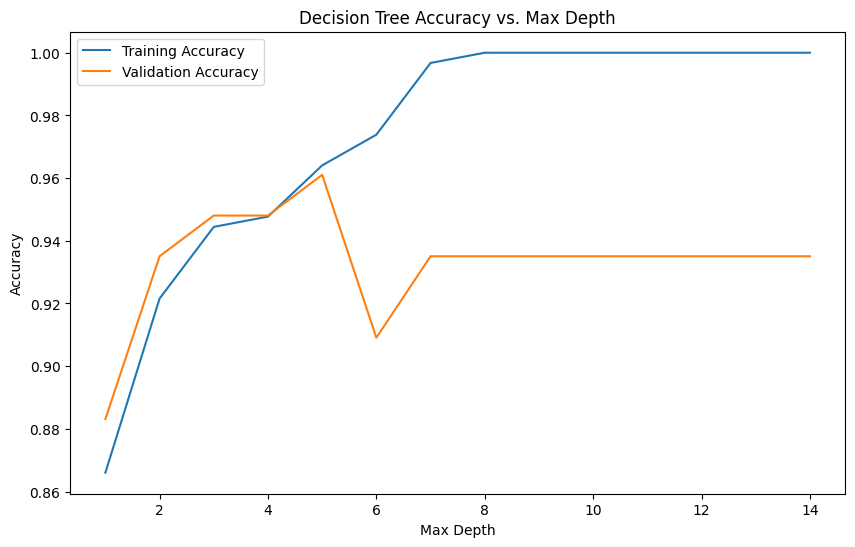

In [28]:
max_depth_range = range(1, 15)

# Run pruning and evaluation
prune_tree_and_evaluate(X_train, y_train, X_test, y_test, max_depth_range)